In [1]:
# Import necessary libraries
import sys
sys.path.append('../noise')

from fnal import Dataset
from utilities import plot_planes, plot_crate, plot_tpc, plot_wire_planes, plot_waveform, plot_ffts, plot_planes_new

# Set base path for saved figures
figure_path = '/Users/mueller/data/signoise_plots/'

In [2]:
# Load the data.
input_path = '/Users/mueller/data/noise/epoch0/'
data = Dataset(f'/Users/mueller/data/noise/epoch0/run10265_new.root')

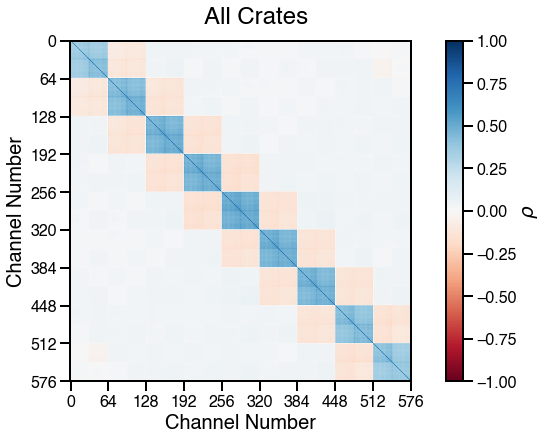

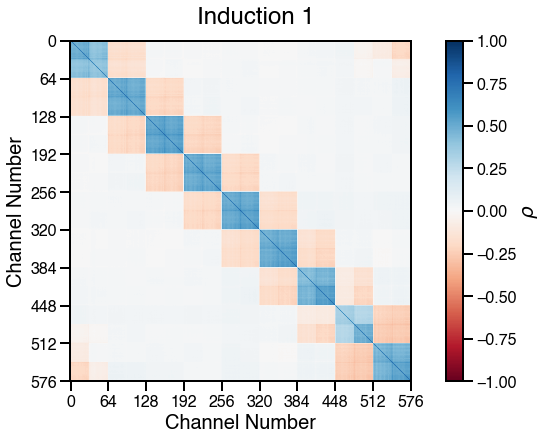

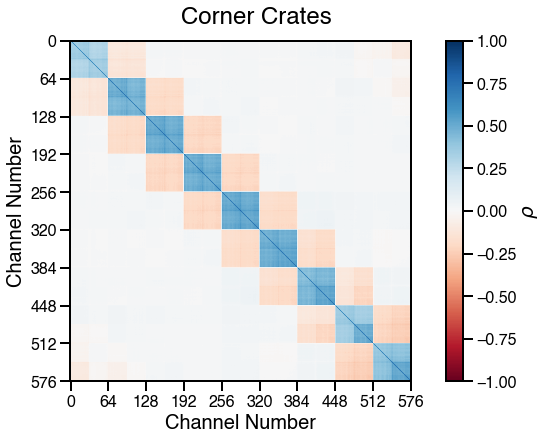

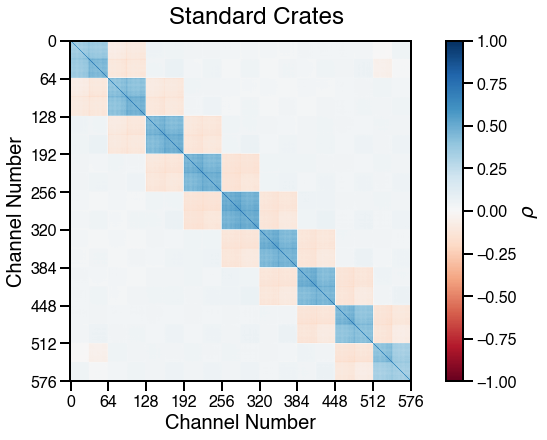

In [3]:
data.plot_correlation_matrix('all', save_path=f'{figure_path}correlation_data_all.png')
data.plot_correlation_matrix('ind1', save_path=f'{figure_path}correlation_data_ind1.png')
data.plot_correlation_matrix('corner', save_path=f'{figure_path}correlation_data_corner.png')
data.plot_correlation_matrix('standard', save_path=f'{figure_path}correlation_data_standard.png')

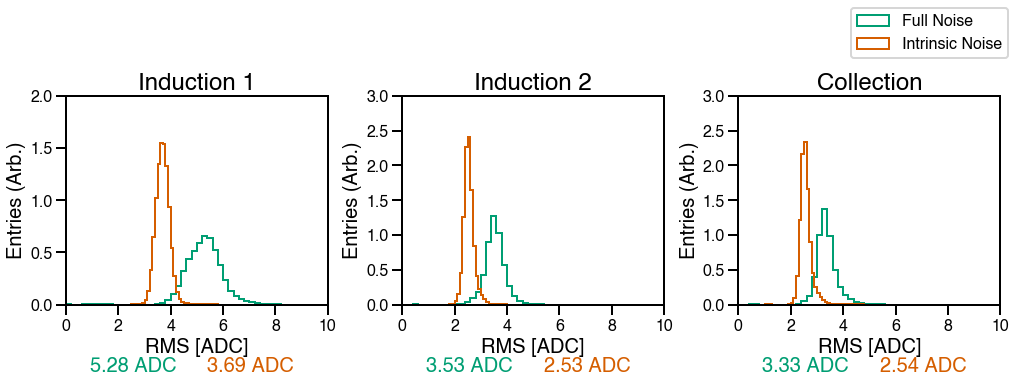

In [4]:
labels = ['Full Noise', 'Intrinsic Noise']
plot_planes_new(data, labels, ['!raw_rms', '!int_rms'], title=' ', normalize=True, cap=[2.0, 3.0, 3.0], wired_only=True, save_path=f'{figure_path}absolute_data_noise.png')

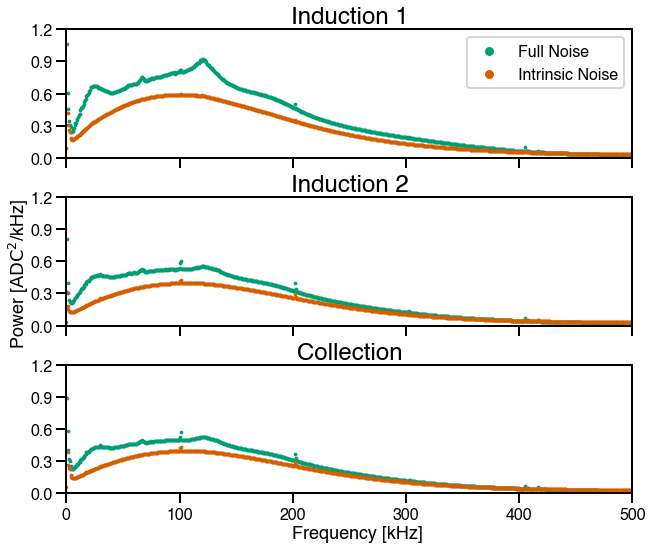

In [5]:
labels = ['Full Noise', 'Intrinsic Noise']
plot_ffts(data, labels, ['raw', 'int'], save_path=f'{figure_path}ffts_data_noise.png')

In [6]:
montecarlo = Dataset(f'/Users/mueller/data/montecarlo_rev2.root')

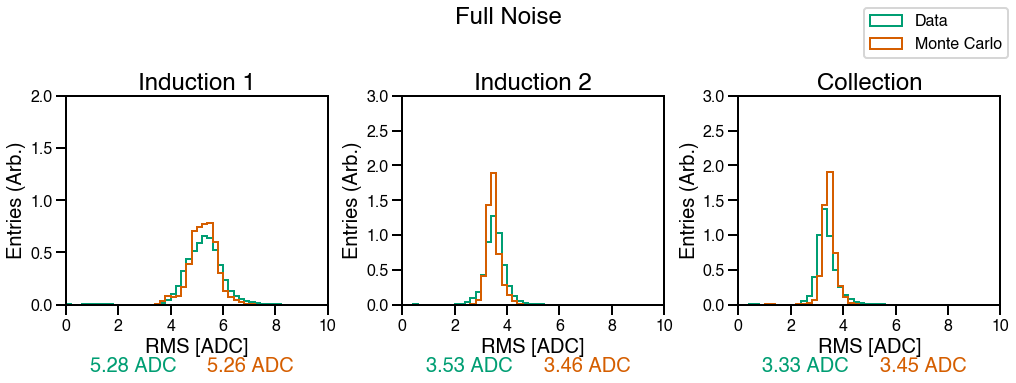

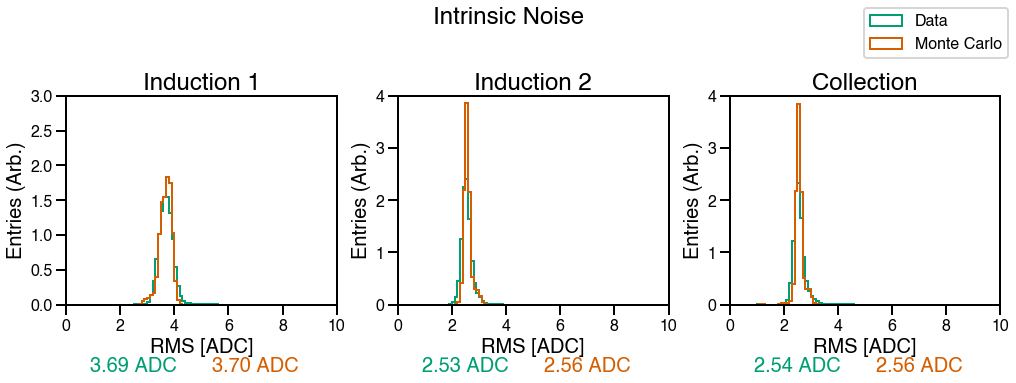

In [7]:
labels = ['Data', 'Monte Carlo']
plot_planes_new([data, montecarlo], labels, '!raw_rms', title='Full Noise', normalize=True, cap=[2.0, 3.0, 3.0], wired_only=True, save_path=f'{figure_path}absolute_comparison_raw.png')
plot_planes_new([data, montecarlo], labels, '!int_rms', title='Intrinsic Noise', normalize=True, cap=[3.0, 4.0, 4.0], wired_only=True, save_path=f'{figure_path}absolute_comparison_intrinsic.png')

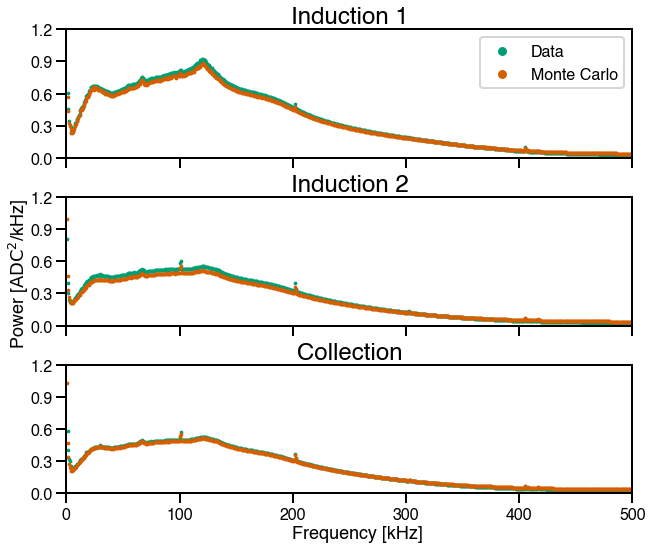

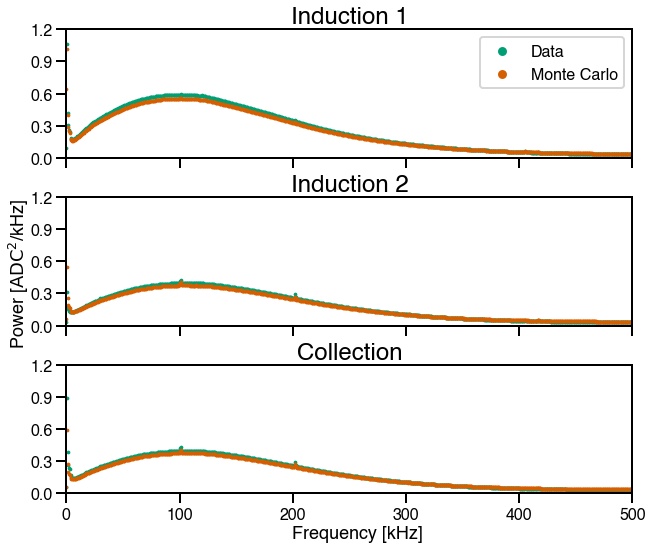

In [8]:
plot_ffts([data, montecarlo], labels, 'raw', save_path='/Users/mueller/data/signoise_plots/ffts_comparison_raw.png')
plot_ffts([data, montecarlo], labels, 'int', save_path='/Users/mueller/data/signoise_plots/ffts_comparison_intrinsic.png')